In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import glob
import sys

from math import *
import pickle

import torch
import torch.nn as nn
from torch.nn import Parameter
from torch.nn import functional as F
import torch.optim
from torch.autograd import Variable
from PIL import Image

from IPython import display
import time
import tqdm

import copy

def tovar(x):
    return Variable(torch.FloatTensor(x).cuda(), requires_grad = False)

def toivar(x):
    return Variable(torch.LongTensor(x).cuda(), requires_grad = False)

## SoftKNN

This layer implements an attention mechanism based on Euclidean distance. Inputs take the form of a source of Keys, Values, and Queries, which can all be the same or different.

Key and Query inputs are embedded into the same space, and distances between them are used to derive a weighting factor. The Values are projected into an output space, multiplied by the weighting factor, and summed.

The 'masking' flag indicates whether to apply a causal mask, so that the Nth element of x can only attend to the 1..Nth elements of the memory. This lets us train on entire sequences of play in parallel.

In [2]:
class SoftKNN(nn.Module):
    def __init__(self, Nfeat1, Nfeat2, Ndim, Nval, alpha = 1, masking = False):
        super(SoftKNN, self).__init__()
        self.tokey = nn.Conv1d(Nfeat1,Ndim,1)
        self.toval = nn.Conv1d(Nfeat2,Nval,1)
        self.alpha = alpha
        self.masking = masking
    
    def attention(self, mem, x):
        xmem = self.tokey(mem)
        xc = self.tokey(x)
        
        # w = BATCH x 1 x LOOKUP x MEMORY
        w = torch.clamp(self.alpha*torch.sqrt(torch.sum( (xc.unsqueeze(3)-xmem.unsqueeze(2))**2, 1, keepdim=True ) + 1e-8), 0, 30)
        w = torch.exp(-w)
        
        if self.masking:
            # We want to mask out values of w in the future
            # This means that w[:,:,i,j] => 0 for j>i

            ls = w.size()[2]
            ms = w.size()[3]
            xidx,yidx = np.meshgrid(np.arange(ls), np.arange(ms))
            mask = tovar(yidx<=xidx).unsqueeze(0).unsqueeze(1)
            w = w*mask
        
        w = w/(torch.sum(w,3,keepdim=True) + 1e-8)
        
        return w
        
    def forward(self, memx, memy, x):        
        w = self.attention(memx, x)
        zmem = self.toval(memy)
        
        # v = BATCH x VAL x LOOKUP
        v = torch.sum(w*zmem.unsqueeze(2),3)        
        
        return v


## Guessing game task

We pick a random number from 0 to 255. Each round, the agent submits a guess, and receives an observation based on whether the guess was high, low, or correct.

Guesses are encoded along with the observation and stored in self.seq, which we can reference to provide inputs to the agent for its next decision.

We use a thermometer encoding for guesses rather than one-hot encoding or continuous values as it balances maintaining the structure of the number line (which is lost with one-hot encoding) with having a high precision as to specifically what guess was rendered (which is lost with continuous values).

In [3]:
G = 256

class Guessing():
    def __init__(self):
        self.number = np.random.randint(G)
        self.reward = 0
        self.t = 0
        
    def guess(self,x):
        self.t += 1
        if x<self.number:            
            return 0
        elif x>self.number:
            return 1
        else:
            return 2

## Network definition

We have three streams of information:

### Query
The 'Query' stream needs to adequately summarize the current game situation in order to render a meaningful next guess, while at the same time we want to keep track of the actual way in which the model tries to evaluate this current situation. To this end, rather than using a single attentional lookup (e.g. SoftKNN layer), we use a sequence of them. The result is that the network starts from an initial state of knowing nothing, internally asks a question as to the current state in the form of a memory lookup, uses the answer to that question to ask the next question, and so on. As a result, the internal dynamics correspond somewhat to the actual structure of the guessing game.

### State/Action
The 'State/Action' stream in this case takes each past guess (without knowledge of the outcome) and embeds it into the SoftKNN Key space.

### Outcome
The 'Outcome' stream takes the combination of each past guess and its outcome, and embeds it into the SoftKNN Value space. In this embedding process, we allow each outcome to access the information contained in the other guesses via two SoftKNN attentional lookups. This makes the structure of the embedding space dependent on what is known so far (e.g. points in memory are not embedded independently). 

Since this is done only in the Outcome stream, it has no effect on the 'virtual' points introduced into memory to propose potential questions and compute saliency.

## Vanishing gradients and normalization

Because we have multiple attentional layers in sequence, there is a potential problem with vanishing gradients at the start of training. By adding residual connections between the densely connected layers and applying Instance Normalization after all attentional layers, we avoid these issues. The residual connections provide an easy path for gradients to flow which allows them to skip the layer until it has trained up to providing some useful modification, and the normalization ensures that values do not collapse onto a single point which would be hard to recover from.

In [4]:
 def Normalize(z):
    mu = torch.mean(z,1,keepdim=True)
    std = 1e-16 + torch.std(z,1,keepdim=True)
    
    return (z-mu)/std

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        # Inputs are (action, action+outcome) memory and (state)
        # State is a hidden state derived from an RNN parsing the memory up to a certain point
        
        # Everything is stored in batch x features x seq
        
        # We summarize the game so far using an LSTM layer which reads the sequence of guesses so far in order
        # This becomes the 'question' associated with the current stage
        #self.lstm = nn.LSTM(3+G,128)
        
        # Embedding of the guesses
        self.atoh1 = nn.Conv1d(G,128,1)
        self.atoh2 = nn.Conv1d(128,128,1)
        self.atoh3 = nn.Conv1d(128,128,1)
        
        # Embedding of the outcomes
        self.otoh1 = nn.Conv1d(G+3,128,1)
        self.odknn = SoftKNN(128,128,8,128)
        self.otoh2 = nn.Conv1d(128,128,1)
        self.otoh3 = nn.Conv1d(128,128,1)
        self.odknn2 = SoftKNN(128,128,8,128)
        self.otoh4 = nn.Conv1d(128,128,1)
        self.otoh5 = nn.Conv1d(128,128,1)
        
        # We are going to ask a sequence of questions internally
        # using the attention mechanism. We have to start somewhere,
        # so this is given by the initial query vector which is always the same
        # 
        # Subsequently, this is modified by a sequence of lookups using SoftKNN
        # We can capture the saliency from each of these lookups and combine them
        # to determine the next guess.
        self.queryvector = Parameter(torch.FloatTensor(np.zeros((1,128,1))))
        
        self.sdknn1 = SoftKNN(128,128,8,128)
        self.stos1 = nn.Conv1d(128,128,1)
        self.stos2 = nn.Conv1d(128,128,1)
        
        self.sdknn2 = SoftKNN(128,128,8,128)
        self.stos3 = nn.Conv1d(128,128,1)
        self.stos4 = nn.Conv1d(128,128,1)        
        
        self.sdknn3 = SoftKNN(128,128,8,128)
        self.stos5 = nn.Conv1d(128,128,1)
        self.stos6 = nn.Conv1d(128,128,1)
        
        self.pred = nn.Conv1d(128,G,1)
        
        self.adam = torch.optim.Adam(self.parameters(), lr=1e-4)
            
    def predict(self, a, o, s):
        # Embed the guesses
        za = F.relu(self.atoh1(a))
        za = F.relu(self.atoh2(za))
        za = F.relu(self.atoh3(za))
        
        # Embed the outcomes, with normalization after attentional layers
        zo = F.relu(self.otoh1(torch.cat([a,o],1)))
        zo = Normalize(zo + self.odknn(zo,zo,zo))
        zo = zo + self.otoh3(F.relu(self.otoh2(zo)))
        zo = Normalize(zo + self.odknn2(zo,zo,zo))
        zo = zo + self.otoh5(F.relu(self.otoh4(zo)))
        
        # Iteratively search memory for information to predict the number
        s = self.queryvector.expand_as(s)
        query1 = self.sdknn1.tokey(s)
        zs = Normalize(s + self.sdknn1(za, zo, s))
        zs = zs + self.stos2(F.relu(self.stos1(zs)))
        query2 = self.sdknn2.tokey(zs)
        zs = Normalize(zs + self.sdknn2(za, zo, zs))        
        zs = zs + self.stos4(F.relu(self.stos3(zs)))        
        query3 = self.sdknn3.tokey(zs)
        
        # Final attentional layer output replaces zs, so the prediction depends strictly on what
        # was pulled from memory in the last lookup
        zs = self.sdknn3(za,zo,zs)
        
        # Postprocess and make a prediction
        zs = F.relu(self.stos5(zs))
        zs = F.relu(self.stos6(zs))
        
        p = F.log_softmax(self.pred(zs),dim=1)
        
        return p, query1, query2, query3

In [5]:
net = Net().cuda()

In [6]:
# Generate 200k guessing games for training
GEN_DATA = False

if GEN_DATA:
    labels = []
    acts = []
    obs = []

    for i in range(200000):
        game = Guessing()   
        lenc = np.zeros(G)
        lenc[game.number] = 1
        labels.append(lenc)
        oseq = []
        aseq = []

        # Initial 'blank' to have some memory contents at the start of the game
        oseq.append(np.zeros(3))
        aseq.append(np.zeros(G))

        for j in range(30):
            act = np.random.randint(G)
            game.guess(act)
            aenc = np.zeros(G)
            aenc[0:act+1] = 1
            aseq.append(aenc)
            oenc = np.zeros(3)
            if act == game.number:
                oenc[2] = 1
            elif act < game.number:
                oenc[0] = 1
            else:
                oenc[1] = 1
            oseq.append(oenc)

        oseq = np.array(oseq) # 10 x 3
        aseq = np.array(aseq) # 10 x G

        oseq = oseq.transpose(1,0)
        aseq = aseq.transpose(1,0)

        acts.append(aseq)
        obs.append(oseq)

    acts = np.array(acts)
    obs = np.array(obs)
    labels = np.array(labels)

In [7]:
# Train the network
TRAIN = False

if TRAIN:
    errs = []

    for epoch in range(50):
        err = 0

        for i in range(labels.shape[0]//500):
            idx = i*500 + np.arange(500)

            y = tovar(labels[idx]).unsqueeze(2).expand((500,256,31))

            ma = tovar(acts[idx])
            mo = tovar(obs[idx])

            net.zero_grad()
            
            # We have to input a 'blank' which holds the problem geometry, but the value of s
            # will be replaced with the queryvector parameter
            s = tovar(np.zeros((500,128,31)))
            p,q1,q2,q3 = net.predict(ma,mo,s)
            
            # Categorical cross-entropy loss for each point in the game sequence
            loss = -torch.mean((y*p).sum(1))
            loss.backward()
            net.adam.step()
            err += loss.cpu().data.numpy()[0]/400.0

        errs.append(err)

        plt.clf()
        plt.plot(errs)

        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(0.01)
else:
    # Load already trained network
    net.load_state_dict(torch.load("models/guessing_network_epoch150.pth"))

In [236]:
# Save the trained network

torch.save(net.state_dict(), open("models/guessing_network.pth","wb"))

## Test results

In [11]:
# The getSaliency function lets us inspect the saliency patterns of the attentional layers for a given
# sequence of play

def getSaliency(aseq, oseq):
    # aseq is going to be LEN x G
    # oseq is going to be LEN x 3
    
    ma = tovar(np.array(aseq)).unsqueeze(0).transpose(2,1)
    mo = tovar(np.array(oseq)).unsqueeze(0).transpose(2,1)
    
    s = tovar(np.zeros((1,128,mo.size()[2])))
    p,q1,q2,q3 = net.predict(ma,mo,s)
    
    # Target point queries
    q1 = q1[:,:,-1]
    q2 = q2[:,:,-1]
    q3 = q3[:,:,-1]
    
    new_act = np.zeros((256,256,1))
    for i in range(256):
        new_act[i,0:i+1,0] = 1
    
    ma = ma.expand(256,ma.size()[1],ma.size()[2])
    ma = torch.cat([ma,tovar(new_act)],2)
    
    za = F.relu(net.atoh1(ma))
    za = F.relu(net.atoh2(za))
    za = F.relu(net.atoh3(za))
    
    za1 = net.sdknn1.tokey(za)
    za2 = net.sdknn2.tokey(za)
    za3 = net.sdknn3.tokey(za)

    za1 = za1[:,:,-1]
    za2 = za2[:,:,-1]
    za3 = za3[:,:,-1]
    
    w1 = torch.exp(-torch.sqrt(torch.sum((za1-q1)**2,1))).cpu().data.numpy()
    w2 = torch.exp(-torch.sqrt(torch.sum((za2-q2)**2,1))).cpu().data.numpy()
    w3 = torch.exp(-torch.sqrt(torch.sum((za3-q3)**2,1))).cpu().data.numpy()
    
    w1 = w1/(1e-16+np.sum(w1))
    w2 = w2/(1e-16+np.sum(w2))
    w3 = w3/(1e-16+np.sum(w3))
    
    return w1,w2,w3

# This finds the best guess using saliency
def optimizeAction(aseq, oseq):
    w1,w2,w3 = getSaliency(aseq, oseq)
    
    maxidx = np.argmax(w3,axis=0)
    return maxidx

# This function returns the predictions of the network as to what the number could be
def getPrediction(aseq, oseq):
    ma = tovar(np.array(aseq)).unsqueeze(0).transpose(2,1)
    mo = tovar(np.array(oseq)).unsqueeze(0).transpose(2,1)
    
    s = tovar(np.zeros((1,128,mo.size()[2])))
    p,q1,q2,q3 = net.predict(ma,mo,s)
    
    p = np.exp(p.cpu().data.numpy()[0,:,-1])
    p = p/np.sum(p)
    
    return p
 
# This function chooses actions according to the network's predictions
def makePrediction(aseq, oseq):
    p = getPrediction(aseq, oseq)
    
    act = np.random.choice(np.arange(G), p=p)
    
    return act


In [12]:
# Take a given action policy such as optimizing saliency or picking according to the prediction,
# and play a bunch of games using it. Track the success rate of the algorithm as a function of
# move number

def getWinCurve(actionFunction):
    wincurve = np.zeros(20)
    for i in tqdm.tqdm_notebook(range(1024)):
        game = Guessing()   
        game.number = i%256
        oseq = []
        aseq = []
        oseq.append(np.zeros(3))
        aseq.append(np.zeros(G))

        iswin = 0
        for j in range(20):
            act = actionFunction(aseq, oseq)

            game.guess(act)
            aenc = np.zeros(G)
            aenc[0:act+1] = 1
            aseq.append(aenc)
            oenc = np.zeros(3)
            if act == game.number:
                oenc[2] = 1
                iswin = 1
            elif act < game.number:
                oenc[0] = 1
            else:
                oenc[1] = 1
            oseq.append(oenc)
            wincurve[j] += iswin/1024.0
    
    return wincurve

In [ ]:
saliency_curve = getWinCurve(optimizeAction)

In [ ]:
prediction_curve = getWinCurve(makePrediction)

In [15]:
binary_curve = np.zeros(20)

for n in range(256):
    minv = 0
    maxv = 255
    winstate = 0
    
    for i in range(20):
        guess = int((maxv + minv)/2)
        if guess==n:
            winstate = 1
        if guess<n:
            minv = guess+1
        if guess>n:
            maxv = guess-1
        
        binary_curve[i] += winstate/256.0

In [16]:
# This is 'passive' inference, where we just guess uniformly out of all possible remaining values each step
random_curve = np.zeros(20)

for j in range(1024):
    n = j%256
    minv = 0
    maxv = 255
    winstate = 0
    
    for i in range(20):
        guess = minv + np.random.randint(maxv-minv+1)
        if guess==n:
            winstate = 1
        if guess<n:
            minv = guess+1
        if guess>n:
            maxv = guess-1
        
        random_curve[i] += winstate/1024.0

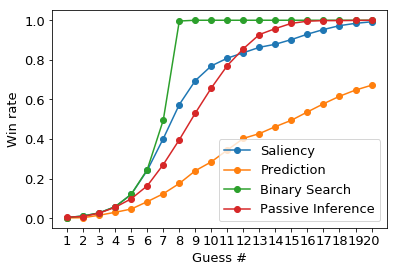

In [22]:
plt.rcParams.update({'font.size': 13})
plt.plot(1+np.arange(20), saliency_curve, 'o-', label="Saliency")
plt.plot(1+np.arange(20), prediction_curve, 'o-', label="Prediction")
plt.plot(1+np.arange(20), binary_curve, 'o-', label="Binary Search")
plt.plot(1+np.arange(20), random_curve, 'o-', label="Passive Inference")
plt.xlabel("Guess #")
plt.ylabel("Win rate")
plt.xticks(1+np.arange(20))
plt.legend()
plt.savefig("guessing_winrate.pdf")

## Visualize saliency patterns

In [23]:
game = Guessing()   
game.number = 233
oseq = []
aseq = []
oseq.append(np.zeros(3))
aseq.append(np.zeros(G))
s1 = []
s2 = []
s3 = []
p = []

iswin = 0
for j in range(20):
    act = optimizeAction(aseq, oseq)
    pred = getPrediction(aseq, oseq)
    d1,d2,d3 = getSaliency(aseq, oseq)
    s1.append(d1)
    s2.append(d2)
    s3.append(d3)
    p.append(pred)
    
    game.guess(act)
    aenc = np.zeros(G)
    aenc[0:act+1] = 1
    aseq.append(aenc)
    oenc = np.zeros(3)
    if act == game.number:
        oenc[2] = 1
        iswin = 1
    elif act < game.number:
        oenc[0] = 1
    else:
        oenc[1] = 1
    oseq.append(oenc)

In [24]:
aseq = np.array(aseq)
s1 = np.array(s1)
s2 = np.array(s2)
s3 = np.array(s3)
p = np.array(p)

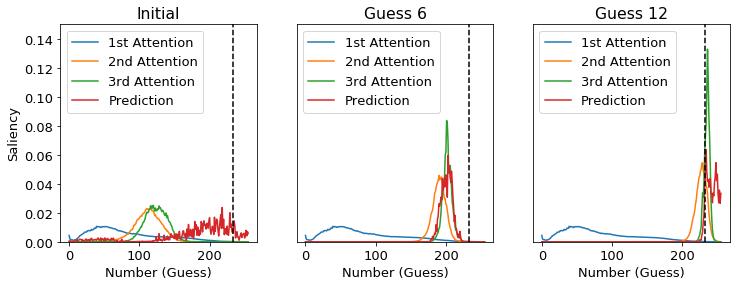

In [33]:
plt.subplot(1,3,1)
plt.plot(s1[0], label="1st Attention")
plt.plot(s2[0], label="2nd Attention")
plt.plot(s3[0], label="3rd Attention")
plt.plot(p[0], label="Prediction")
plt.axvline(233,c='k',ls='--')
plt.xlabel("Number (Guess)")
plt.ylabel("Saliency")
plt.ylim(0,0.15)
plt.legend(loc=2)
plt.title("Initial")

plt.subplot(1,3,2)
plt.plot(s1[6], label="1st Attention")
plt.plot(s2[6], label="2nd Attention")
plt.plot(s3[6], label="3rd Attention")
plt.plot(p[4], label="Prediction")
plt.axvline(233,c='k',ls='--')
plt.legend()
plt.ylim(0,0.15)
plt.yticks([])
plt.xlabel("Number (Guess)")
plt.title("Guess 6")

plt.subplot(1,3,3)
plt.plot(s1[12], label="1st Attention")
plt.plot(s2[12], label="2nd Attention")
plt.plot(s3[12], label="3rd Attention")
plt.plot(p[12], label="Prediction")
plt.yticks([])
plt.axvline(233,c='k',ls='--')
plt.legend()
plt.title("Guess 12")
plt.ylim(0,0.15)
plt.xlabel("Number (Guess)")

plt.gcf().set_size_inches((12,4))
plt.savefig("saliency.pdf")